# Overview

The shelter wants a model that detects animals that are prone to unfavorable outcomes in order to give them even more help in finding a home.

In [4]:
import pandas as pd, matplotlib.pyplot as plt, seaborn as sns, numpy as np

%matplotlib inline

In [5]:
train = pd.read_csv('../data/train.csv')
test = pd.read_csv('../data/test.csv')
sample = pd.read_csv('../data/sample_submission.csv')

# Exploratory Data Analysis

In [6]:
# check if columns match between training and test data
print len(train.columns), sorted(train.columns)
print len(test.columns), sorted(test.columns)

10 ['AgeuponOutcome', 'AnimalID', 'AnimalType', 'Breed', 'Color', 'DateTime', 'Name', 'OutcomeSubtype', 'OutcomeType', 'SexuponOutcome']
8 ['AgeuponOutcome', 'AnimalType', 'Breed', 'Color', 'DateTime', 'ID', 'Name', 'SexuponOutcome']


In [7]:
train.describe()

,AnimalID,Name,DateTime,OutcomeType,OutcomeSubtype,AnimalType,SexuponOutcome,AgeuponOutcome,Breed,Color
count,26729,19038,26729,26729,13117,26729,26728,26711,26729,26729
unique,26729,6374,22918,5,16,2,5,44,1380,366
top,A705677,Max,2015-08-11 00:00:00,Adoption,Partner,Dog,Neutered Male,1 year,Domestic Shorthair Mix,Black/White
freq,1,136,19,10769,7816,15595,9779,3969,8810,2824


In [8]:
train.head()

,AnimalID,Name,DateTime,OutcomeType,OutcomeSubtype,AnimalType,SexuponOutcome,AgeuponOutcome,Breed,Color
0,A671945,Hambone,2014-02-12 18:22:00,Return_to_owner,NaN,Dog,Neutered Male,1 year,Shetland Sheepdog Mix,Brown/White
1,A656520,Emily,2013-10-13 12:44:00,Euthanasia,Suffering,Cat,Spayed Female,1 year,Domestic Shorthair Mix,Cream Tabby
2,A686464,Pearce,2015-01-31 12:28:00,Adoption,Foster,Dog,Neutered Male,2 years,Pit Bull Mix,Blue/White
3,A683430,NaN,2014-07-11 19:09:00,Transfer,Partner,Cat,Intact Male,3 weeks,Domestic Shorthair Mix,Blue Cream
4,A667013,NaN,2013-11-15 12:52:00,Transfer,Partner,Dog,Neutered Male,2 years,Lhasa Apso/Miniature Poodle,Tan


In [9]:
test.head()

,ID,Name,DateTime,AnimalType,SexuponOutcome,AgeuponOutcome,Breed,Color
0,1,Summer,2015-10-12 12:15:00,Dog,Intact Female,10 months,Labrador Retriever Mix,Red/White
1,2,Cheyenne,2014-07-26 17:59:00,Dog,Spayed Female,2 years,German Shepherd/Siberian Husky,Black/Tan
2,3,Gus,2016-01-13 12:20:00,Cat,Neutered Male,1 year,Domestic Shorthair Mix,Brown Tabby
3,4,Pongo,2013-12-28 18:12:00,Dog,Intact Male,4 months,Collie Smooth Mix,Tricolor
4,5,Skooter,2015-09-24 17:59:00,Dog,Neutered Male,2 years,Miniature Poodle Mix,White


In [10]:
# checking specfic data type of each column
for col in train.columns:
    print col, type(train[col].head(1).values[0])

AnimalID <type 'str'>
Name <type 'str'>
DateTime <type 'str'>
OutcomeType <type 'str'>
OutcomeSubtype <type 'float'>
AnimalType <type 'str'>
SexuponOutcome <type 'str'>
AgeuponOutcome <type 'str'>
Breed <type 'str'>
Color <type 'str'>


Check number of uniques per column anticipating if dummifying is feasible; curse of dimensionality concern


In [11]:
for col in train.columns:
    uniques = train[col].unique()
    print col, len(uniques), uniques
    print

AnimalID 26729 ['A671945' 'A656520' 'A686464' ..., 'A698128' 'A677478' 'A706629']

Name 6375 ['Hambone' 'Emily' 'Pearce' ..., 'Mowmow' 'Sonja' 'Green Bean']

DateTime 22918 ['2014-02-12 18:22:00' '2013-10-13 12:44:00' '2015-01-31 12:28:00' ...,
 '2015-05-14 11:56:00' '2015-03-09 13:33:00' '2014-04-27 12:22:00']

OutcomeType 5 ['Return_to_owner' 'Euthanasia' 'Adoption' 'Transfer' 'Died']

OutcomeSubtype 17 [nan 'Suffering' 'Foster' 'Partner' 'Offsite' 'SCRP' 'Aggressive'
 'Behavior' 'Rabies Risk' 'Medical' 'In Kennel' 'In Foster' 'Barn'
 'Court/Investigation' 'Enroute' 'At Vet' 'In Surgery']

AnimalType 2 ['Dog' 'Cat']

SexuponOutcome 6 ['Neutered Male' 'Spayed Female' 'Intact Male' 'Intact Female' 'Unknown'
 nan]

AgeuponOutcome 45 ['1 year' '2 years' '3 weeks' '1 month' '5 months' '4 years' '3 months'
 '2 weeks' '2 months' '10 months' '6 months' '5 years' '7 years' '3 years'
 '4 months' '12 years' '9 years' '6 years' '1 weeks' '11 years' '4 weeks'
 '7 months' '8 years' '11 months' '4 

Value counts for the different outcomes shows a class imbalance. Need to decide if we are going to oversample or undersample each of the different outcomes.

In [12]:
outcomes_counts = train['OutcomeType'].value_counts()

The classes we are interested in detecting are `Euthanasia` and `Died` because these are the ones that did not find a home in the end. These classes are also undersampled.

In [13]:
outcomes_counts

Adoption           10769
Transfer            9422
Return_to_owner     4786
Euthanasia          1555
Died                 197
Name: OutcomeType, dtype: int64

In [26]:
sns.set # matplotlib defaults

rc={'figure.figsize': (20,8), 'axes.labelsize': 24, 'font.size': 40., 'legend.fontsize': 20.0,\
    'axes.titlesize': 20}

plt.rcParams.update(**rc)
    
%config InlineBackend.figure_format = 'retina'

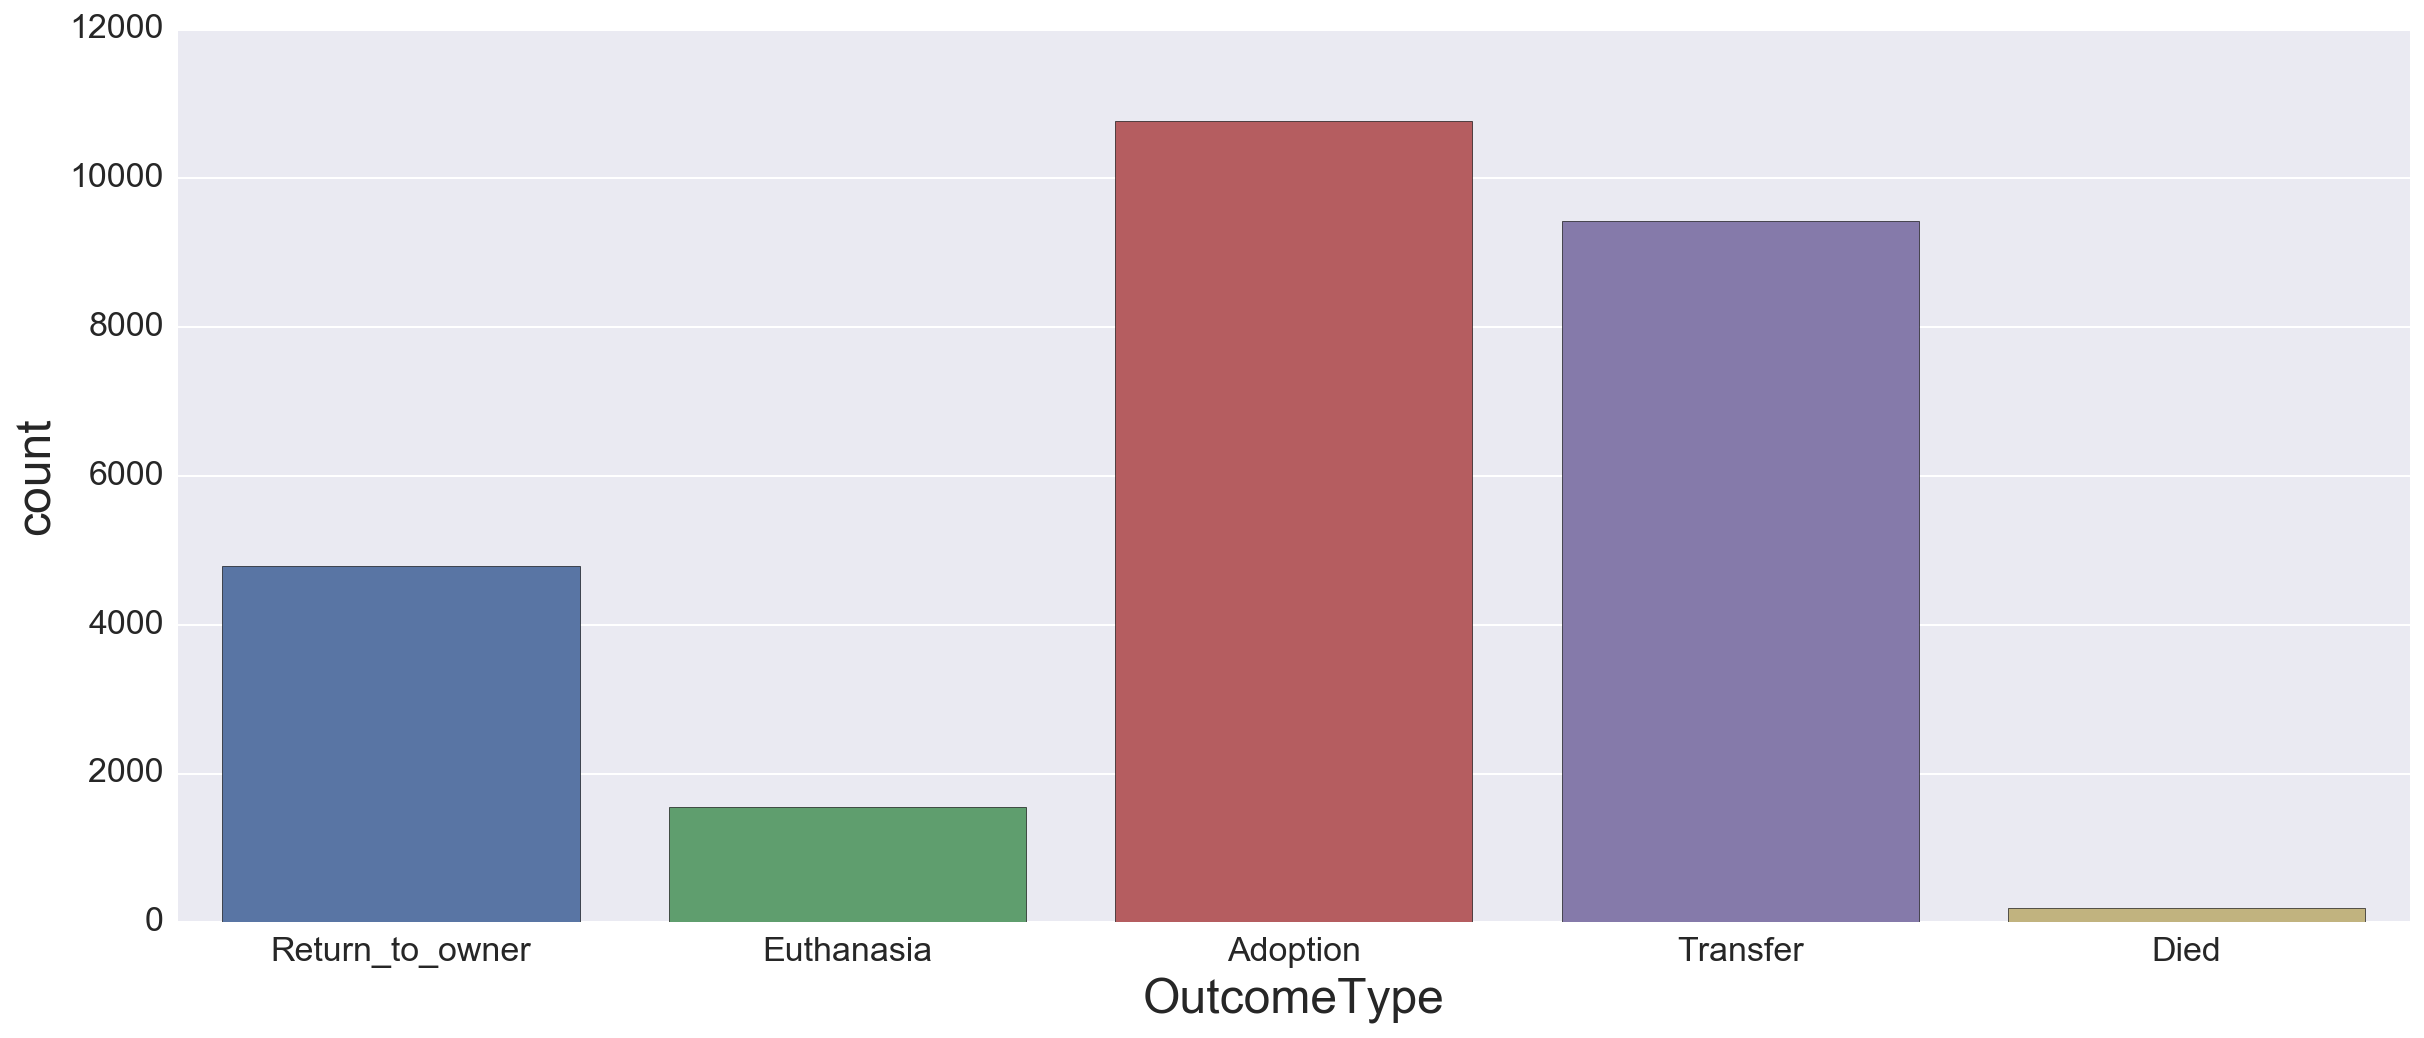

In [27]:
# visualization of unbalanced outcome classes
ax = sns.countplot(train['OutcomeType'])
ax.tick_params(axis='both', labelsize=17)

In [28]:
# glimpse top names
print train['Name'].value_counts().head()
print

# how many unique names? 6,375
print len(train['Name'].unique()), "unique pet names" # too many unique names to dummify; curse of dimensionality 
print

# 29% have no names; extract a hasName feature?
print "Percentage Name Nulls", train[train['Name'].isnull()].shape[0] / float(train.shape[0]) # too many nulls to simply drop

Max        136
Bella      135
Charlie    107
Daisy      106
Lucy        94
Name: Name, dtype: int64

6375 unique pet names

Percentage Name Nulls 0.287739907965


Reasons for dropping OutcomeSubtype when creating our model:

+ Test set has no OutcomeSubtype column
+ Our model will not know OutcomeSubtype because knowledge of OutcomeSubtype occurs at the time of OutcomeType. This is an example of target leakage.

However, there are some interesting observations made from studying OutcomeSubtype:
+ Adoptions tend to be to foster homes
+ When animals die for reasons other than euthanasia, they tend to be in the kennel or in foster care
+ Animals are euthanized mainly for suffering and aggressive behavior
+ When transferred, animals to to either another partner shelter or the SCRP

In [17]:
# count of OutcomeSubtype
train.groupby(['OutcomeType', 'OutcomeSubtype']).count()

AnimalID  Name  DateTime  AnimalType  \
OutcomeType OutcomeSubtype                                              
Adoption    Barn                        1     0         1           1   
            Foster                   1800  1542      1800        1800   
            Offsite                   165   132       165         165   
Died        At Vet                      4     3         4           4   
            Enroute                     8     1         8           8   
            In Foster                  52    29        52          52   
            In Kennel                 114    35       114         114   
            In Surgery                  3     2         3           3   
Euthanasia  Aggressive                320   278       320         320   
            Behavior                   86    74        86          86   
            Court/Investigation         6     6         6           6   
            Medical                    66    38        66          66   
            Rabies Risk                74    43        74          74   
            Suffering                1002   301      1002        1002   
Transfer    Barn                        1     1         1           1   
            Partner                  7816  4436      7816        7816   
            SCRP                     1599    58      1599        1599   

                                 SexuponOutcome  AgeuponOutcome  Breed  Color  
OutcomeType OutcomeSubtype                                                     
Adoption    Barn                              1               1      1      1  
            Foster                         1800            1800   1800   1800  
            Offsite                         165             165    165    165  
Died        At Vet                            4               4      4      4  
            Enroute                           8               8      8      8  
            In Foster                        52              52     52     52  
            In Kennel                       114             114    114    114  
            In Surgery                        3               3      3      3  
Euthanasia  Aggressive                      320             320    320    320  
            Behavior                         86              86     86     86  
            Court/Investigation               6               6      6      6  
            Medical                          66              66     66     66  
            Rabies Risk                      74              74     74     74  
            Suffering                      1002            1000   1002   1002  
Transfer    Barn                              1               1      1      1  
            Partner                        7816            7816   7816   7816  
            SCRP                           1599            1583   1599   1599

### Exploring sample_submission.csv to understand how to make a submission

In [18]:
# check submission format
sample.head()

,ID,Adoption,Died,Euthanasia,Return_to_owner,Transfer
0,1,1,0,0,0,0
1,2,1,0,0,0,0
2,3,1,0,0,0,0
3,4,1,0,0,0,0
4,5,1,0,0,0,0
